# Graphical Estimators
-------------------------------------

With the explosive success of neural networks over the past few years, we often forget one these models' major drawbacks - **lacking interpretability**.

In genomics, classifying genes responsible for cancerous cells is one of the most sought after problems. However, understanding *how* and *why* a model learns to predict the way it does is as important as the predictions themselves. 

Business analytics and marketing intelligence is yet another field where interpretability of predictions often takes central role. Moreover, domain knowledge of a particular market often calls for a specification of dependancies between various variables. Encoding such dependancies in a neural network is not a simple task. 

In this tutorial, we will construct a new type of estimator that addresses both the issue of interpretability and specification of dependancies among variables.

In [1]:
# import modules we will be using
import numpy as np
import pandas as pd
import networkx as nx

# We will use grid searching capabilities provided
# by scikit-learn as an inner operation of our own
# grid searcher.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Our graphical model will be able to select the best of these estimators
# for each set of input_nodes -> output_node pairs.
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor # The almighty extreme gradient boost algorithm

# A utility module that allows dictionary access
# through dot notaion (i.e., print(dictionary.key))
from dotmap import DotMap

## Model Architecture
------------------------------

The simplest way to understanding how graphical estimators are structures is by example. Let's first look at a simple model.

### Case 1

![Basic](basic.png)

This graph defines a variable $Z$, with dependancies $X$ and $Y$. Note that $X$ and $Y$ are independent variables with their respective _observed_ data sets. We will refer to variables as _nodes_ in the context of the graphical estimator. Node $Z$ will contain an _observed_ data set, as well as an estimator to generate predictions based on the **active path** $(X, Y) \rightarrow Z$.

Suppose we query the graph for the node $Z$. Since none of its dependancies are modified, the graph outputs the observed data set of $Z$. No inference is required. The _active path_ of the query is just $Z$. However, if for example, the data set of $X$ is modified, then node $Z$ will rely on it's estimator to predict the output from the combination of the the modified data of $X$ and the observed data of $Y$. In such a scenario, the _active path_ established by querying the graph for $Z$ changes from $Z$ to $(X_{modified}, Y) \rightarrow Z$.

Let's now look at a slighly larger graph.

### Case 2

![Harder](harder.png)

The graph on the left is queried for node $O$. The data set of node $K$ is modified up the initiation of the query. Since $K$ is provided a new input data, the active path does not include any of the ancestors of $K$. $O$'s estimator is used to combine the observed data of $W$ and the modified data of $K$ to predict $O$. The active path is $(W, K_{modified}) \rightarrow O$.

The graph on the right is also queried for node $O$. This time however, the top level node $X$ is modified, activating the estimators of all of it's descendants. First, $W$ is predicted from $X$ and $Y$. $O$ is then predicted from $W_{predicted}$ and $K$. Note that in this query $K$ is not dependent on $Z$. The active path here is $((X, Y) \rightarrow W, K) \rightarrow O$.

## MetaGridSearchCV
-----------------------------

With a large number of potential interactions between nodes, it may be time consuming to handcraft models for each input/output interaction. We define a grid search mechanism that adds a space of estimators as a hyperparameter to be tuned.

In [59]:
class MetaGridSearchCV(object):
    """A hyper parameter tuning mechanism that accepts estimators as hyperparameters."""
    def __init__(self, estimators):
        self.estimators = estimators
        self.best_estimator_ = None
        self.best_score_ = None
        self.active_estimator_ = None

    def fit(self, features, labels, verbose=False):
        for estimator in self.estimators:
            clf = GridSearchCV(
                    estimator.model,
                    estimator.grid, # grid of hyperparameters for this `estimator.model`
                    verbose=verbose,
            )

            clf.fit(features, labels)
            estimator.model = clf.best_estimator_

            if self.best_score_ is None or clf.best_score_ < self.best_score_:
                self.best_score_ = clf.best_score_
                self.best_estimator_ = estimator
                self.active_estimator_ = estimator
                
                if verbose:
                    print('New best estimator:', estimator.name)

    def predict(self, X):
        """Make predictions using the active estimator's model."""
        predictions = self.active_estimator_.model.predict(X)
        # Need the result to have ndim 2. 
        # scikit-learn's fit function wants dim 1 vector labels...arrrr
        predictions = predictions.reshape((-1, 1))
        
        return predictions

For the sake of this example, we define a few estimators that will form the estimator space. Note that the hyperparameters of each model are specified for keep this tutorial clean.

In [60]:
XGBHyperRegressor = DotMap()
XGBHyperRegressor.model = XGBRegressor()
XGBHyperRegressor.grid = {
            'learning_rate': [0.01, 0.03, 0.1, 0.3],
}
XGBHyperRegressor.name = 'XGBHyperRegressor'

RandomForestHyperRegressor = DotMap()
RandomForestHyperRegressor.model = RandomForestRegressor()
RandomForestHyperRegressor.grid = {
            'n_estimators': [600, 800, 1000],
}
RandomForestHyperRegressor.name = 'RandomForestHyperRegressor'

LinearHyperRegression = DotMap()
LinearHyperRegression.model = LinearRegression()
LinearHyperRegression.grid = {}
LinearHyperRegression.name = 'LinearHyperRegression'

AdaBoostHyperRegressor = DotMap()
AdaBoostHyperRegressor.model = AdaBoostRegressor()
AdaBoostHyperRegressor.grid = {
        'base_estimator': [
            RandomForestRegressor(),
            DecisionTreeRegressor()
        ],
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.03, 0.1, 0.3]
}
AdaBoostHyperRegressor.name = 'AdaBoostHyperRegressor'

Equipped with _MetaGridSearchCV_, we are ready to define our graph estimator.

In [61]:
class PGraph(nx.DiGraph):
    """Implementation of a graphical estimator."""
          
    def query(self, node, mod_dict={}):
        """Query the graph for the output of `node`."""
        
        modified = mod_dict.keys()
        
        def query_recursive(node):
            if node in modified:
                return mod_dict[node]
            elif not nx.ancestors(self, node).intersection(modified):
                return self.node[node]['observed']
            else:
                features = [query_recursive(predecessor) for \
                            predecessor in self.predecessors(node)]
                # Stack the features column wise, forming the input 
                # vectors for this node.
                features = np.concatenate(features, axis=1)
                
                return self.node[node]['meta_grid'].predict(features)

        return query_recursive(node)

    def fit(self, nodes=None, verbose=False):
        """Train `nodes`' estimators.
        
        If `nodes` in None, all the nodes in the graph are trained.
        """
        if nodes is None:
            nodes = self.nodes()

        for node in nodes:
            features = [self.node[predecessor]['observed'] for \
                        predecessor in self.predecessors(node)]
            
            # top level nodes don't have any predecessors, so there is nothing
            # to train for top level nodes.
            if features:
                
                # Stack the features column wise, forming the input 
                # vectors for this node.
                features = np.concatenate(features, axis=1)
                
                grid = MetaGridSearchCV(self.node[node]['models'])
                if verbose:
                    print('Fitting node:', node)
                # Scikit-learn gridsearchcv complains if the labels are not rank 1...
                grid.fit(features, self.node[node]['observed'].ravel(), verbose=verbose)
        
                # save the best model
                self.node[node]['meta_grid'] = grid

## Example
----------------

**Scenario**: Image you are a company that has an annual marketing budget distributed over two channels: _TV_ and _Radio_. These drive people to your website, and you keep track of these _Sessions_. Some of your web site visitors are impressed with your product and some of the _Sessions_ turn into _Orders_. The question you would like to answer is: **what is the response rate of _Orders_ if I modify _TV_ spend?**

Here is what the graph estimator and the active path look like for this scenario

![example](example.png)

In [62]:
from sklearn.preprocessing import RobustScaler

# ==================================================== Create a toy dataset ====================================================
NUM_EXAMPLES = 5000

# Note that the graphical estimators requires the data two have rank at least 2
# in order to stack data of parent nodes horizontally when running a query on a node.
tv_spend = np.random.rand(NUM_EXAMPLES, 1)
radio_spend = np.random.rand(NUM_EXAMPLES, 1)
sessions = 0.7*tv_spend + 0.4*radio_spend + np.random.rand(NUM_EXAMPLES, 1) # Approximately linear function of spends
orders = 3*sessions**0.5 + np.random.rand(NUM_EXAMPLES, 1) # Approximately square root function of sessions

# ================================================ Create a graphical estimator ================================================
PG = PGraph()

PG.add_node('tv_spend', observed=tv_spend)
PG.add_node('radio_spend', observed=radio_spend)
PG.add_node('sessions', observed=sessions, models=[LinearHyperRegression, RandomForestHyperRegressor])
PG.add_node('orders', observed=orders, models=[AdaBoostHyperRegressor, XGBHyperRegressor])

# ================================================ Specify the graph dependencies ==============================================
PG.add_edges_from([('tv_spend', 'sessions'), ('radio_spend', 'sessions'), ('sessions', 'orders')])

                      
# ======================================================= Train the model ======================================================
PG.fit(verbose=True)

Fitting node: sessions
Fitting 3 folds for each of 1 candidates, totalling 3 fits
New best estimator: LinearHyperRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.9s finished


New best estimator: RandomForestHyperRegressor
Fitting node: orders
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  8.2min finished


New best estimator: AdaBoostHyperRegressor
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished


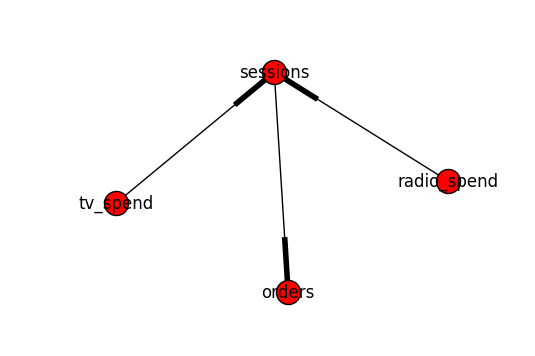

In [75]:
# We can verify our graph architecture using
# native plotting in networkx
import matplotlib.pyplot as plt

f, ax = plt.subplots(1)
nx.draw(PG, ax=ax, with_labels=True)
plt.show()

Lets start modifying _TV_ spending and plot the response rate of _Orders_.

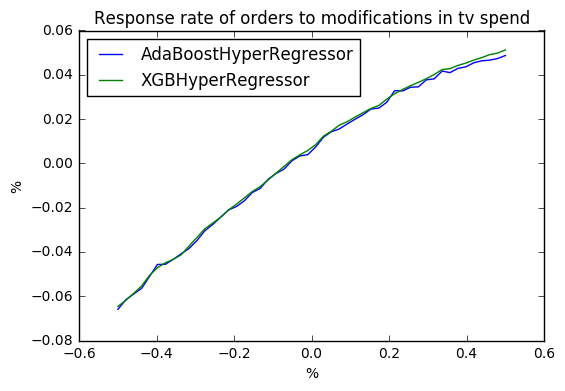

In [69]:
# ================================================ Linear percent inc./dec. space ==============================================
percent = np.linspace(-0.5, 0.5, num=50)
base = np.sum(PG.node['orders']['observed'])
target = PG.node['orders']

for estimator in target['meta_grid'].estimators:
    target['meta_grid'].active_estimator_ = estimator
    percent_changes = []

    for p in percent:
        pred = PG.query('orders', mod_dict={
            'tv_spend':  (1 + p) * PG.node['tv_spend']['observed'],
        })
        percent_changes.append((np.sum(pred) - base) / base)
    plt.plot(percent, percent_changes, label=estimator.name)

plt.title('Response rate of orders to modifications in tv spend')
plt.xlabel('%')
plt.ylabel('%')
plt.legend(loc='best')
plt.show()